# Deep Learning of the Extreme Value Index

Estimating the extreme value index, which describes the tail behavior of Pareto-type distributions, is a complex task and estimators usually depend on the choice of a threshold, above which the data can be used for statistical inference on extreme events. <br>
The question I want to discuss here is: Can I train a network on random samples to determine the extreme value index without the selection of a threshod?

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import random

np.random.seed(42)
tf.set_random_seed(42)

In the following the training data is generated. For the network to learn well it is very important to obtain training samples, which represent a broad class of distributions. <br>
Since I am working on samples from heavy-tailed distributions, which can include extremely high values, I can not use the samples directly for training the network. Instead of the raw obervations I look at their logarithm. This trick leads to a more reasonable range of observed values and is also a natural thing to do in extreme value statistics, as it leads to an exponential approximation of the peak-over-threshold approach instead of a pareto approximation.

In [3]:
N=500
M=5000

train_data=np.zeros((3*M,N))
labels=np.zeros(3*M)

for i in range(M):
    degree=np.random.randint(1,12)
    X=np.random.standard_t(df=degree, size=N)
    train_data[i,]=np.log(abs(X))
    labels[i]=1./degree
    
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    train_data[M+i,]=np.log(X)
    labels[M+i]=gamma

for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=np.random.uniform(size=N)
    X=np.power((1/(1-X) -1), gamma)
    train_data[2*M+i,]=np.log(X)
    labels[2*M+i]=gamma
    

## The network architecture

In the case considered here, where the input does not contain structral properties, the only useful network is a fully connnected sequential model.

In [4]:
modelH=tf.keras.models.Sequential()
modelH.add(tf.keras.layers.Dense(N, input_shape=(N,) , activation='relu', use_bias=True))
modelH.add(tf.keras.layers.Dense(2*N, activation='relu', use_bias=True ))
modelH.add(tf.keras.layers.Dense(N, activation='relu', use_bias=True ))
modelH.add(tf.keras.layers.Dense(1, use_bias=True))

modelH.compile(optimizer='adam', loss='mse', metrics=["mae"])
#RMSprop each model varies a lot
#SGD leads  to nan
#with Adam the loss can increase by times

Just a short check, if the initialized function values are not too far away from the true labels. Starting values that are by orders of magnitude higher or smaller than the true label values would lead too a very slow training speed.

In [5]:
modelH.predict(train_data)

array([[-0.16088665],
       [-0.93340528],
       [-0.55824888],
       ..., 
       [-0.48357075],
       [ 0.16883616],
       [-0.02772872]], dtype=float32)

In [6]:
test_data=np.zeros((3*M,N))
test_labels=np.zeros(3*M)

for i in range(M):
    degree=np.random.randint(1,12)
    X=np.random.standard_t(df=degree, size=N)
    test_data[i,]=np.log(abs(X))
    test_labels[i]=1./degree
    
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    test_data[M+i,]=np.log(X)
    test_labels[M+i]=gamma

for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=np.random.uniform(size=N)
    X=np.power((1/(1-X) -1), gamma)
    test_data[2*M+i,]=np.log(X)
    test_labels[2*M+i]=gamma
    

In [7]:
modelH.fit(train_data, labels, epochs=50, validation_data=(test_data, test_labels))

Train on 15000 samples, validate on 15000 samples
Epoch 1/50
15000/15000 [==============================] - 5s 346us/step - loss: 0.5350 - mean_absolute_error: 0.2062 - val_loss: 0.0182 - val_mean_absolute_error: 0.0937
Epoch 2/50
15000/15000 [==============================] - 5s 323us/step - loss: 0.0124 - mean_absolute_error: 0.0796 - val_loss: 0.0154 - val_mean_absolute_error: 0.0858
Epoch 3/50
15000/15000 [==============================] - 5s 319us/step - loss: 0.0081 - mean_absolute_error: 0.0663 - val_loss: 0.0147 - val_mean_absolute_error: 0.0836
Epoch 4/50
15000/15000 [==============================] - 5s 325us/step - loss: 0.0058 - mean_absolute_error: 0.0572 - val_loss: 0.0156 - val_mean_absolute_error: 0.0857
Epoch 5/50
15000/15000 [==============================] - 5s 319us/step - loss: 0.0048 - mean_absolute_error: 0.0521 - val_loss: 0.0135 - val_mean_absolute_error: 0.0813
Epoch 6/50
15000/15000 [==============================] - 5s 319us/step - loss: 0.0050 - mean_absolu

Epoch 49/50
15000/15000 [==============================] - 5s 317us/step - loss: 0.0032 - mean_absolute_error: 0.0358 - val_loss: 0.0239 - val_mean_absolute_error: 0.1020
Epoch 50/50
15000/15000 [==============================] - 5s 320us/step - loss: 0.0032 - mean_absolute_error: 0.0355 - val_loss: 0.0241 - val_mean_absolute_error: 0.1006


## The comparison for fixed sample size

Now I want to test the networks performance on samples from a Frechet(2) and a Cauchy distribution, where the true extreme value index is 1/2 and 1 respectively. Both distibutions are commonly usd examples in extreme value analsis.

In [17]:
M=500
## Frechet(2)
test_dataFl=np.zeros((M,N))
test_dataF=np.zeros((M,N))
test_labelsF=np.zeros(M)
    
for i in range(M):
    gamma=1/2
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    test_dataFl[i,]=np.log(X)
    test_dataF[i,]=X
    test_labelsF[i]=gamma
    
    
## Cauchy
test_dataCl=np.zeros((M,N))
test_dataC=np.zeros((M,N))
test_labelsC=np.zeros(M)

for i in range(M):
    X=np.random.standard_cauchy(size=N)
    test_dataCl[i,]=np.log(abs(X))
    test_dataC[i,]=X
    test_labelsC[i]=1

I want to compare it to a more "traditional" statistical procedure and therefore I implemented the method K_star, which I developed for threshold selection and adaptive estimation of the extreme value index using the Hill estimator.

In [18]:
def Hill(X,k):
    N=len(X)
    X=np.sort(X)
    temp=np.log(X[range(N-k-1,N)])-np.log(X[N-k-1])
    return(np.sum(temp)/(k+1))

def de_Vries(X,k):
    N=len(X)
    X=np.sort(X)
    temp=np.log(X[range(N-k-1,N)])-np.log(X[N-k-1])
    temp2=np.power(temp,2)
    return(np.sum(temp2)/(2*np.sum(temp)))

In [19]:
def K_star(X):
    n_p=sum(1 for i in range(len(X)) if X[i]>0)
    K=range(4,n_p)
    H=np.zeros(len(K))
    V=np.zeros(len(K))
    Error=np.zeros(len(K))
    for k in K:
        H[k-K[0]]=Hill(X,k)
        V[k-K[0]]=de_Vries(X,k)
        Hk=H[range(k-K[0]+1)]
        Vk=V[range(k-K[0]+1)]
        upHk=(np.cumsum(Hk[::-1]) / range(1, len(Hk)+1))[::-1]
        Error[k-K[0]]=np.mean(np.power(Hk-Vk-upHk+upHk[0],2))
    Stable=np.zeros(len(K))
    for k in K:
        Stable[k-K[0]]=np.mean(np.power( (Error[k-K[0]]-Error[range(max(0,k-K[0]-2),min(len(K)-1,k-K[0]+2))]) ,2))
        
    kstar=K[np.argmin(Stable)]
    upHk=(np.cumsum(H[kstar-K[0]::-1]) / range(1,kstar-K[0]+2))[::-1]
    MSE=np.zeros(len(range(4,kstar+1)))
    for k in range(4,kstar+1):
        MSE[k-4]=(2*V[kstar-K[0]]-H[kstar-K[0]])**2/k+4*(upHk[k-4]-upHk[0])**2
        
    return K[np.argmin(MSE)]

In [20]:
Gamma_hatF=np.zeros(500)

for i in range(500):
    X=test_dataF[i,]
    k1=K_star(X)
    Gamma_hatF[i]=Hill(X,k1)
    
    
Gamma_hatC=np.zeros(500)

for i in range(500):
    X=test_dataC[i,]
    k1=K_star(X)
    Gamma_hatC[i]=Hill(X,k1)

Now we can compare the performance of the method K_star to the deep neural network (DNN) in terms of the mean square error (MSE) and the mean absolute error (MAE). We obseve that the DNN performs better in both examples. Although our method K_star is maybe not the optimal thing you can do, it performs quite comparable to other methods. Thus, it offers a realistic evaluation of the estimation performance of the neural network.

K_star - Frechet - MSE: 0.00486883484553 , MAE: 0.0534270257877
500/500 [==============================] - 0s 61us/step
DNN - Frechet - MSE: 0.00137717017718 , MAE: 0.0299174061716


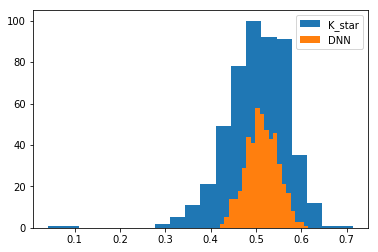

In [21]:
print("K_star - Frechet - MSE:", np.mean(np.power((Gamma_hatF-test_labelsF),2)),", MAE:", np.mean(np.abs((Gamma_hatF-test_labelsF))))
EvF=modelH.evaluate(test_dataFl, test_labelsF)
print("DNN - Frechet - MSE:", EvF[0], ", MAE:", EvF[1])

plt.hist(Gamma_hatF, bins=20, label="K_star")
plt.hist(modelH.predict(test_dataFl), bins=20, label="DNN")
legend = plt.legend()
plt.show()

K_star - Cauchy - MSE: 0.0361568715126 , MAE: 0.149241513737
500/500 [==============================] - 0s 64us/step
DNN - Cauchy - MSE: 0.0125199482366 , MAE: 0.0971328452826


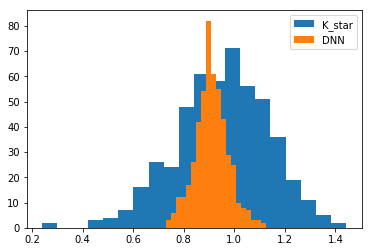

In [22]:
print("K_star - Cauchy - MSE:", np.mean(np.power((Gamma_hatC-test_labelsC),2)),", MAE:", np.mean(np.abs((Gamma_hatC-test_labelsC))))
EvC=modelH.evaluate(test_dataCl, test_labelsC)
print("DNN - Cauchy - MSE:", EvC[0], ", MAE:", EvC[1])

plt.hist(Gamma_hatC, bins=20, label="K_star")
plt.hist(modelH.predict(test_dataCl), bins=20, label="DNN")
legend = plt.legend()
plt.show()

## Considering different sample sizes

A major drawback of such a network is that the architecture determines the number of observations, which can be processed. Thus, you would either train and possibly model an new network for each sample sizes your are confronted with or you rather consider drawing from you data with replacement to obtain samples of the same size. The second approach makes sense, if you have a various samples which do not very drastically. <br>

To evaluate this idea the test data gereated in the following has different sample sizes, but in constrast to the K_star method the DNN is applied to resampled versions of size N.

In [46]:
M=500
dif=200
## Frechet(2)
test_dataFlv=np.zeros((M,N))
test_dataFv=np.zeros((M,N+dif))
test_labelsFv=np.zeros(M)
    
for i in range(M):
    gamma=1/2
    Nr=np.random.randint(N-dif,N+dif)
    Xr=stat.invweibull.rvs(c=1/gamma, size=Nr)
    if Nr>=N:
        X=np.asarray(random.sample(list(Xr),N))
    else:
        X=np.zeros(N)
        for j in range(N):
            X[j]=random.choice(Xr)
    test_dataFlv[i,]=np.log(X)
    test_dataFv[i,:len(Xr)]=Xr
    test_labelsFv[i]=gamma
    
    
## Cauchy
test_dataClv=np.zeros((M,N))
test_dataCv=np.zeros((M,N+dif))
test_labelsCv=np.zeros(M)

for i in range(M):
    Nr=np.random.randint(N-dif,N+dif)
    Xr=np.random.standard_cauchy(size=Nr)
    if Nr>=N:
        X=np.asarray(random.sample(list(Xr),N))
    else:
        X=np.zeros(N)
        for j in range(N):
            X[j]=random.choice(Xr)
    test_dataClv[i,]=np.log(abs(X))
    test_dataCv[i,:len(Xr)]=Xr
    test_labelsCv[i]=1

In [47]:
Gamma_hatFv=np.zeros(500)

for i in range(500):
    X=test_dataFv[i,][test_dataFv[i,]>0]
    k1=K_star(X)
    Gamma_hatFv[i]=Hill(X,k1)
    
    
Gamma_hatCv=np.zeros(500)

for i in range(500):
    X=test_dataCv[i,][test_dataCv[i,]>0]
    k1=K_star(X)
    Gamma_hatCv[i]=Hill(X,k1)

K_star - Frechet - MSE: 0.00523065245957 , MAE: 0.0558326050504
500/500 [==============================] - 0s 60us/step
DNN - Frechet - MSE: 0.00190217754804 , MAE: 0.03346574229


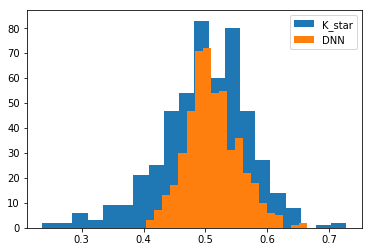

In [48]:
print("K_star - Frechet - MSE:", np.mean(np.power((Gamma_hatFv-test_labelsFv),2)),", MAE:", np.mean(np.abs((Gamma_hatFv-test_labelsFv))))
EvF=modelH.evaluate(test_dataFlv, test_labelsFv)
print("DNN - Frechet - MSE:", EvF[0], ", MAE:", EvF[1])

plt.hist(Gamma_hatFv, bins=20, label="K_star")
plt.hist(modelH.predict(test_dataFlv), bins=20, label="DNN")
legend = plt.legend()
plt.show()

K_star - Cauchy - MSE: 0.0366999681922 , MAE: 0.14403536628
500/500 [==============================] - 0s 71us/step
DNN - Cauchy - MSE: 0.0132186456621 , MAE: 0.0965670490861


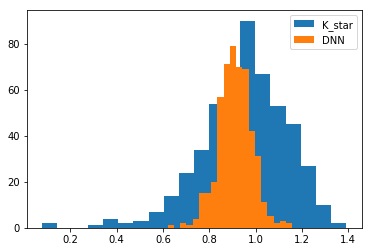

In [49]:
print("K_star - Cauchy - MSE:", np.mean(np.power((Gamma_hatCv-test_labelsCv),2)),", MAE:", np.mean(np.abs((Gamma_hatCv-test_labelsCv))))
EvC=modelH.evaluate(test_dataClv, test_labelsCv)
print("DNN - Cauchy - MSE:", EvC[0], ", MAE:", EvC[1])

plt.hist(Gamma_hatCv, bins=20, label="K_star")
plt.hist(modelH.predict(test_dataClv), bins=20, label="DNN")
legend = plt.legend()
plt.show()

Surprisingly the DNN does not suffer much from the resampling scheme and still peforms better.

## Conclusion

Training neural networks in order to learn the extreme value index without the necessary selection of a threshold or sample fraction seems worth further investigation. It would be very interesenting to get insight on the structure of the network and understand how it larns to estimate this parameter.